#### Importing Libraries

In [32]:
import qiskit as q
import qiskit.visualization as qv
import numpy as np

from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.tools.monitor import job_monitor
from qiskit.circuit.library import GroverOperator

import matplotlib.style
import matplotlib as plt
plt.style.use("dark_background")

#### Defining oracles Uf and Ur

In [109]:
def Uf(n, num, name ="Uf"):
    circuit = QuantumCircuit(n+1)
    x = np.binary_repr(num, n)[::-1]
    for i, j in enumerate(x):
        if j == "0":
            circuit.x(i)
    
    circuit.mcx(list(range(n)),n)
    
    for i, j in enumerate(x):
        if j == "0":
            circuit.x(i)
    
    return circuit

Uf(3,5).draw()

q_0: ───────■───────
     ┌───┐  │  ┌───┐
q_1: ┤ X ├──■──┤ X ├
     └───┘  │  └───┘
q_2: ───────■───────
          ┌─┴─┐     
q_3: ─────┤ X ├─────
          └───┘

In [110]:
def diffuser(n, name = "Diffuse"):
    circuit = QuantumCircuit(n+1)
    circuit.h(range(n))
    circuit.x(range(n))
    circuit.mcx(list(range(n)),n)
    circuit.x(range(n))
    circuit.h(range(n))
    return circuit

diffuser(3).draw()

┌───┐┌───┐     ┌───┐┌───┐
q_0: ┤ H ├┤ X ├──■──┤ X ├┤ H ├
     ├───┤├───┤  │  ├───┤├───┤
q_1: ┤ H ├┤ X ├──■──┤ X ├┤ H ├
     ├───┤├───┤  │  ├───┤├───┤
q_2: ┤ H ├┤ X ├──■──┤ X ├┤ H ├
     └───┘└───┘┌─┴─┐└───┘└───┘
q_3: ──────────┤ X ├──────────
               └───┘

In [113]:
n = 4; num = 10

grover = QuantumCircuit(n+1,n)
nsol = 1 # No. of Solutions

# Initialize the total number of times we pass the oracles
r = int(np.floor(np.pi/4*np.sqrt(2**n)/nsol))

grover.h(range(n))

#Initiate Last Qubit in |-> state
grover.x(n) 
grover.h(n) 

#Apply r rounds of Uf and Diffuser Circuits
for i in range(r):
    grover.append( Uf(n, num), grover.qubits[0:n+1] )
    grover.append( diffuser(n), grover.qubits[0:n+1] )

grover.measure(range(n),range(n))
grover.draw()

┌───┐     ┌──────────────┐┌──────────────┐┌──────────────┐┌──────────────┐»
q_0: ┤ H ├─────┤0             ├┤0             ├┤0             ├┤0             ├»
     ├───┤     │              ││              ││              ││              │»
q_1: ┤ H ├─────┤1             ├┤1             ├┤1             ├┤1             ├»
     ├───┤     │              ││              ││              ││              │»
q_2: ┤ H ├─────┤2 circuit-239 ├┤2 circuit-242 ├┤2 circuit-245 ├┤2 circuit-248 ├»
     ├───┤     │              ││              ││              ││              │»
q_3: ┤ H ├─────┤3             ├┤3             ├┤3             ├┤3             ├»
     ├───┤┌───┐│              ││              ││              ││              │»
q_4: ┤ X ├┤ H ├┤4             ├┤4             ├┤4             ├┤4             ├»
     └───┘└───┘└──────────────┘└──────────────┘└──────────────┘└──────────────┘»
c: 4/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«     ┌──────────────┐┌──────────────┐┌─┐         
«q_0: ┤0             ├┤0             ├┤M├─────────
«     │              ││              │└╥┘┌─┐      
«q_1: ┤1             ├┤1             ├─╫─┤M├──────
«     │              ││              │ ║ └╥┘┌─┐   
«q_2: ┤2 circuit-251 ├┤2 circuit-254 ├─╫──╫─┤M├───
«     │              ││              │ ║  ║ └╥┘┌─┐
«q_3: ┤3             ├┤3             ├─╫──╫──╫─┤M├
«     │              ││              │ ║  ║  ║ └╥┘
«q_4: ┤4             ├┤4             ├─╫──╫──╫──╫─
«     └──────────────┘└──────────────┘ ║  ║  ║  ║ 
«c: 4/═════════════════════════════════╩══╩══╩══╩═
«                                      0  1  2  3

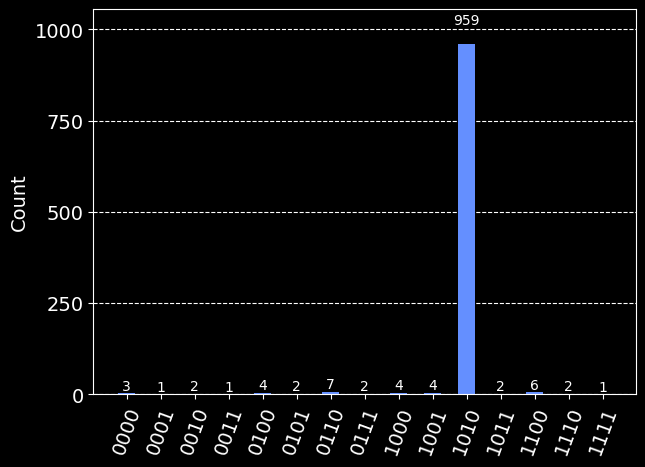

In [114]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 1000
t_grover = transpile(grover, aer_sim)
results = aer_sim.run(t_grover, shots=shots).result()
answer = results.get_counts()

qv.plot_histogram(answer)